In [1]:
import sys
import socket
from struct import *
import zlib
import time
import pandas as pd
import numpy as np

In [2]:
def flatten_tuple(nested_tuple):
    flat_list = []
    for item in nested_tuple:
        if isinstance(item, (list, tuple)):
            flat_list.extend(flatten_tuple(item))
        elif isinstance(item, np.ndarray):
            flat_list.extend(item.flatten().tolist())
        else:
            flat_list.append(item)
    return flat_list

class ReqMsg:
    def __init__(self, request_id=0):
        self.msg_id = 0
        self.request_id = request_id
        msg_time = time.time()
        self.time = int(msg_time)
        self.time_ns = int((msg_time % 1) * 1e9)
        self.data_size_bytes = 0
        self.data_info = (0, ) * 10

    def pack(self, *args):
        b_msg = pack("=2B2iI10B", *flatten_tuple(tuple(vars(self).values())))
        if self.request_id == 1:
            b_msg = b_msg + pack('996x') #dummy
        elif self.request_id == 2: #velocity
            b_msg = b_msg + pack('=2iBf2B981x', *flatten_tuple(args))
        elif self.request_id == 3: #position
            b_msg = b_msg + pack('=2iBf2B981x', *flatten_tuple(args))
        elif self.request_id == 4: #velocity vectro
            b_msg = b_msg + pack('=iB200f191x', *flatten_tuple(args))
        elif self.request_id == 5: #position vectro
            b_msg = b_msg + pack('=iB200f191x', *flatten_tuple(args))
        elif self.request_id == 255:
            b_msg = b_msg + pack('996')
        b_msg = b_msg + pack('I', int(hex(zlib.crc32(b_msg) & 0xffffffff), base=16))
        self.msg_id = self.msg_id + 1
        return b_msg

In [3]:
socket_address = ('127.0.0.1', 1551)

s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM, 0)
msg = ReqMsg(1)

In [4]:
def vec_gen(start, end, number):
    vec = [0] * 200
    if number > 200:
        number = 200
    profile = np.linspace(start, end, number)
    for i in range(number):
        vec[i] = profile[i]
    return vec

In [19]:
msg.request_id = 4
num = 30
vec = vec_gen(10, 5, num)

s.sendto(msg.pack(-1, num, vec), socket_address)

1024

In [7]:
import numpy as np
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt

def lane_change_lateral_shift(lane_width, a_max_comfort, j_max_comfort, speed):
    """
    Compute the lateral shift required for a lane change.

    Parameters:
        lane_width (float): Width of the lane (m). Can be useful if the array size to be fixed to a larger number, say 200. 
        a_max_comfort (float): Maximum comfortable lateral acceleration (m/s²).
        j_max_comfort (float): Maximum comfortable lateral jerk (m/s³).
        waypoints (np.array): Array of waypoints (x, y) with shape (N, 2).
        speeds (np.array): Array of speeds at waypoints (m/s) with shape (N,).

    Returns:
        L (integer): Number of way points (= Total distance to achieve the lane change)
        y (np.array): Lateral shift (offset) profile (m) for each waypoint.
        psi (np.arra): Yaw angle in radians. Can be used to adjust the heading
        
    """
    
    L = speed * np.maximum(2.403*np.sqrt(abs(lane_width)/a_max_comfort),
                           (60*abs(lane_width)/j_max_comfort)**(1/3))
    L = round(L+1)
    s = np.arange(0,L+1) # distance along the curve. Matches with the waypoint ids if distance is 1 m
    
    s_norm = s / L
    # Compute the lateral shift profile
    # Quintic polynomial: y(s) = d*(10*(s/L)^3 - 15*(s/L)^4 + 6*(s/L)^5)
    y = lane_width * (10*s_norm**3 - 15*s_norm**4 + 6*s_norm**5)
    
    # First derivative dy/ds (If yaw to be calculated)
    dyds = lane_width * (30*s_norm**2 - 60*s_norm**3 + 30*s_norm**4) / L
    
    # Heading (psi) is given by the tangent of the curve:
    psi = np.arctan(dyds);  # in radians    

    return L, y, psi

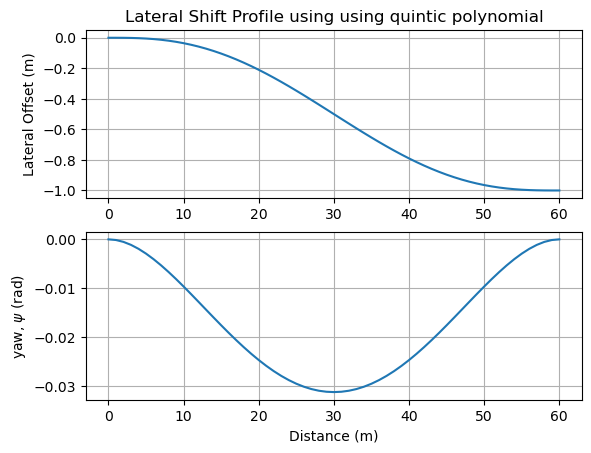

Time estimated for the shift: 4.0s
Lateral Shift Profile (m)[61,60]:
[-0.00000000e+00 -4.51466049e-05 -3.52098765e-04 -1.15812500e-03
 -2.67456790e-03 -5.08777006e-03 -8.56000000e-03 -1.32303781e-02
 -1.92158025e-02 -2.66118750e-02 -3.54938272e-02 -4.59174460e-02
 -5.79200000e-02 -7.15211651e-02 -8.67239506e-02 -1.03515625e-01
 -1.21868642e-01 -1.41741566e-01 -1.63080000e-01 -1.85817508e-01
 -2.09876543e-01 -2.35169375e-01 -2.61599012e-01 -2.89060131e-01
 -3.17440000e-01 -3.46619406e-01 -3.76473580e-01 -4.06873125e-01
 -4.37684938e-01 -4.68773140e-01 -5.00000000e-01 -5.31226860e-01
 -5.62315062e-01 -5.93126875e-01 -6.23526420e-01 -6.53380594e-01
 -6.82560000e-01 -7.10939869e-01 -7.38400988e-01 -7.64830625e-01
 -7.90123457e-01 -8.14182492e-01 -8.36920000e-01 -8.58258434e-01
 -8.78131358e-01 -8.96484375e-01 -9.13276049e-01 -9.28478835e-01
 -9.42080000e-01 -9.54082554e-01 -9.64506173e-01 -9.73388125e-01
 -9.80784198e-01 -9.86769622e-01 -9.91440000e-01 -9.94912230e-01
 -9.97325432e-01 -9.9

In [8]:
# Define input parameters
lane_width = -1  # Lane width (m)
a_max_comfort = 1.5  # Maximum comfortable lateral acceleration (m/s²)
j_max_comfort = 1  # Maximum comfortable lateral jerk (m/s³)

speed = 15           # constant speed.
# Note: If variable speed, the lateral acceleration may vary but if maximum speed is selected, the limits can be ensured    

# Compute lateral shift
L, lateral_shift, psi  = lane_change_lateral_shift(lane_width, a_max_comfort, j_max_comfort, speed)

# Visualizing the profile
#plt.figure(figsize=(5,4))
plt.subplot(2,1,1)
plt.plot(np.arange(0,L+1), lateral_shift)
plt.ylabel('Lateral Offset (m)')
plt.grid()
plt.title('Lateral Shift Profile using using quintic polynomial')
plt.subplot(2,1,2)
plt.plot(np.arange(0,L+1), psi)
plt.ylabel('yaw, $\psi$ (rad)')
plt.xlabel('Distance (m)')
plt.grid()
plt.show()

# Print results
print("Time estimated for the shift: "+ str(L/speed)+"s")
print(f'Lateral Shift Profile (m)[{len(lateral_shift)},{L}]:')
print(lateral_shift)